<a href="https://colab.research.google.com/github/GaikwadSandesh/Coronavirus-Tweet-Sentiment-Analysis/blob/main/Coronavirus_Tweet_Sentiment_Analysis_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

# Data loading and Cleaning

In [ ]:
import numpy as np 
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report,confusion_matrix , accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle
import string
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/Coronavirus Tweets.csv' ,encoding='latin-1')

In [ ]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

 * UserName and ScreenName are very much like id of The screen which are irevent to our problem

In [ ]:
df.drop(columns=['ScreenName' ,'UserName' , ]  , inplace=True)

In [ ]:
pd.concat([df.head(3), df.tail(3)], axis=0)

,Location,TweetAt,OriginalTweet,Sentiment
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
41154,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral
41156,i love you so much || he/him,14-04-2020,@TartiiCat Well new/used Rift S are going for ...,Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Location       32567 non-null  object
 1   TweetAt        41157 non-null  object
 2   OriginalTweet  41157 non-null  object
 3   Sentiment      41157 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB


In [ ]:
df.isnull().sum()

Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
print(round(100*(df.isnull().sum()/len(df.index)),2))

Location         20.87
TweetAt           0.00
OriginalTweet     0.00
Sentiment         0.00
dtype: float64


* Location and Tweet time are also not nedded for the problem but we will do some basic EDA just to understand what type of data we are going through

### Tweet by date

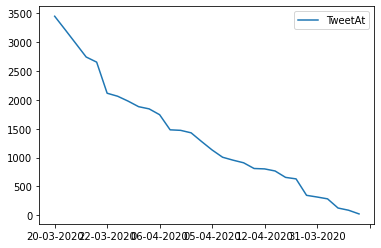

In [ ]:
df['TweetAt'].value_counts().to_frame().plot(kind = 'line')

### Top Location of Tweets

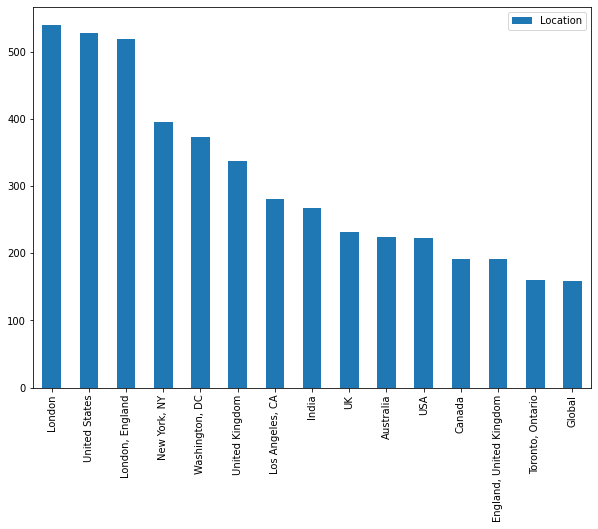

In [ ]:
df['Location'].value_counts().sort_values(ascending=False).to_frame().iloc[:15].plot(kind ='bar' , figsize = (10 , 7) )

In [ ]:
#df.dropna()['Location'].value_counts().to_frame().head(25)

In [ ]:
df.drop(columns=['Location' ,'TweetAt'] , inplace=True) # we don't need Location and tweet date so we will drop this columns

In [ ]:
pd.concat([df.head(3), df.tail(3)], axis=0)

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral
41156,@TartiiCat Well new/used Rift S are going for ...,Negative


## Tweets EDA

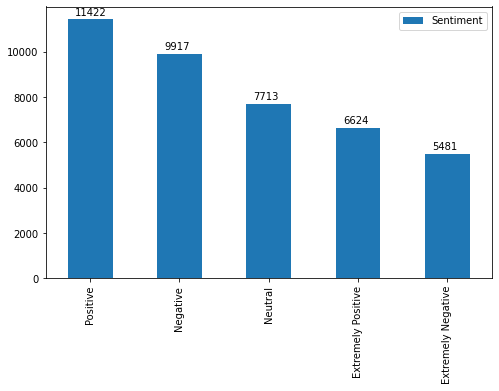

In [ ]:
ax =df['Sentiment'].value_counts().to_frame().plot(kind = 'bar', figsize=(8,5))
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x() +0.08, p.get_height()+200))

In [ ]:
def random_tweet(df , sentiment):
  rand_int = np.random.randint(0 , 6000)
  tweet = df[df['Sentiment']== sentiment].iloc[rand_int ,0]
  print(tweet)
  

In [ ]:
 random_tweet(df , 'Negative')

QPAY cuts POS prices by 50% to help Qatari SMEs fight CoVid-19: QPAY International, a member of the NEXXO Network, the leading financial technology (Fintech) company in Qatar servicing over 15,000 Qatari SmallÂ ... https://t.co/ufT6VKKXNd #fintech


In [ ]:
random_tweet(df , 'Extremely Negative')


Too concerned with their dogma of allowing 'market forces' to prevail no dou


In [ ]:
 random_tweet(df , 'Extremely Positive')

My favorite place to shop during the #coronavirus crisis: H-Mart... When I walked in, there was someone in face mask and gloves ready to squirt hand sanitizer into each customer's hands. Every 5 minutes the PA played a message reminding everyone to physical distance 6 ft. https://t.co/XpVzAbMv3K


In [ ]:
 random_tweet(df , 'Neutral')

Many financial institutionsÂ continuity plans may not fully address the impact of an outbreak like COVID-19. Explore how you can prepare during this time of uncertainty. https://t.co/xw1A0otpLq https://t.co/1lMESLN4bB


We will ony consider tweet column and use NLP based approch to build classifier

# Preprocessing of Tweets column

In [ ]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [ ]:
import nltk
nltk.download('stopwords')
sw = stopwords.words('english') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [ ]:
def remove_pattern(input_txt, pattern):
    '''a function to remove tags and user '''
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

* It is okay if we miss classifying 'extremely positive' into 'positive' or 'negative' into 'extremely negative' but 
Misclassifying an extremely 'positive' into 'extremely negative' will cause a more bad impact.
* Current ml models weight each misclassification equally, to overcome that and observe error, we need ordinal error so we will write encoding for the sentiments and get MSE as ordinal error 

In [ ]:
def seniment_encoding(Sentiment):
  ''' function to do sentiments Encoding'''
  value = 0
  if Sentiment == 'Extremely Negative':
    value = -3 
  elif Sentiment == 'Negative':
    value = -2 
  elif   Sentiment == 'Extremely Positive':   
    value = 3
  elif Sentiment == 'Positive':
    value = 2
  else:
      pass
  return value

In [ ]:
df.Sentiment.unique() 

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [ ]:
df['filtered'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*') # removed all user tag 

In [ ]:
df['filtered'] = df['filtered'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) # removerd all web links

In [ ]:
df['filtered'] = df['OriginalTweet'].apply(remove_punctuation) # remove punctuation marks

In [ ]:
df['filtered'] = df['filtered'].apply(stopwords) # removed all stopwords

In [ ]:
df['filtered'] = df['filtered'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))  # remove words with length smaller than 2

In [ ]:
# create new variable tokenized tweet 
tokenized_tweet = df['filtered'].apply(lambda x: x.split())

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [ ]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
# change df['Tweet'] to tokenized_tweet

df['filtered'] = tokenized_tweet

In [ ]:
df_binary =df.copy()

In [ ]:
df['encode_senti'] =  df['Sentiment'].apply(seniment_encoding)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df['filtered'] , df['encode_senti'],test_size=0.3 , random_state=42)

# Evaluation Metrix

In [ ]:
def array_encoding(array):
  ''' function to do  Encoding'''
  value = np.zeros_like(array)
  for i, elem in enumerate(array):
    if elem in  [-3 , -2] :
      value[i] = -1 
    elif elem in [2 , 3]:
      value[i] = 1
    else:
      value[i] = 0
  return value

In [ ]:
def evaluation_metrics(y_train , y_train_p ,y_test, y_test_p):
  ''' a function to get classification report , 
  heat map , and other errors '''
  MSE_train  = round(mean_squared_error(y_test, y_test_p), 2)
 # print("MSE train:" , MSE_train)
  MSE_test  = round(mean_squared_error(y_train, y_train_p), 2)
 # print("MSE test:" , MSE_test)

  RMSE_train = round(np.sqrt(MSE_train), 2)
  print("RMSE training Error:" ,RMSE_train)
  RMSE_test = round(np.sqrt(MSE_test), 2)
  print("RMSE testing errot:" ,RMSE_test)

  print("\n")
  print("classification report train data")
  print(classification_report(y_train,y_train_p))
  print("\n")
  print("classification report test data")
  print(classification_report(y_test,y_test_p))

  print("Training accuracy Score   : ",accuracy_score(y_train,y_train_p))
  print("Validation accuracy Score : ",accuracy_score(y_test, y_test_p))
  
  print("\n")

  y_train_encode = array_encoding(y_train)
  y_train_p_encode = array_encoding(y_train_p)
  y_test_encode = array_encoding(y_test)
  y_test_p_encode = array_encoding(y_test_p)
  
  print("Training accuracy Score (3 labels )   : ",accuracy_score(y_train_encode,y_train_p_encode))
  print("Validation accuracy Score (3 labels)  : ",accuracy_score(y_test_encode, y_test_p_encode))
  print('\n')
#==============================================================================================================================
  labels = {-3 :'Extremely Negative', -2:'Negative', 0:'Neutral' , 2:'Positive',
       3 :'Extremely Positive'}
  labels_list = ['ENeg', 'Neg', 'Neut' , 'Pst', 'EPst']

  labels_list_encode = ['Neg', 'Neut' , 'EPst']
  confusion_matrix = metrics.confusion_matrix(y_test, y_test_p  , labels = [-3 , -2 , 0 , 2 , 3])
  confusion_matrix_norm = metrics.confusion_matrix(y_test, y_test_p ,normalize='true', labels = [-3 , -2 , 0 , 2 , 3])

  confusion_matrix_encode = metrics.confusion_matrix(y_test_encode, y_test_p_encode  , labels = [-1, 0 , 1])
  confusion_matrix_norm_encode = metrics.confusion_matrix(y_test_encode, y_test_p_encode ,normalize='true', labels = [-1 , 0 , 1]) 

  fig , axis = plt.subplots( 2, 2 , figsize=(18 , 12))
  ax00 = sns.heatmap(confusion_matrix, annot=True, fmt="d" , xticklabels=labels_list ,  yticklabels=labels_list ,ax = axis[0 ,0 ] )
  ax01 = sns.heatmap(confusion_matrix_norm, annot=True, fmt=".4f" , xticklabels=labels_list , yticklabels=labels_list , ax = axis[0 ,1])
  ax10 = sns.heatmap(confusion_matrix_encode, annot=True, fmt="d" , xticklabels=labels_list_encode , yticklabels=labels_list_encode ,ax = axis[1 ,0 ] )
  ax11 = sns.heatmap(confusion_matrix_norm_encode, annot=True, fmt=".4f" , xticklabels=labels_list_encode , yticklabels=labels_list_encode , ax = axis[1 ,1])

  ax00.set_xlabel("Predicted Label", fontsize= 12)
  ax00.set_ylabel("True Label", fontsize= 12)
  ax01.set_xlabel("Predicted Label", fontsize= 12)
  ax01.set_ylabel("True Label", fontsize= 12)
  ax10.set_xlabel("Predicted Label", fontsize= 12)
  ax10.set_ylabel("True Label", fontsize= 12)
  ax11.set_xlabel("Predicted Label", fontsize= 12)
  ax11.set_ylabel("True Label", fontsize= 12)

  plt.show()

# Vectoriser

In [ ]:
# create a count vectorizer object
count_vectorizer = CountVectorizer(max_df =0.80 , min_df = 20)
# fit the count vectorizer using the text data
count_vectorizer.fit(X_train)

CountVectorizer(max_df=0.8, min_df=20)

In [ ]:
train_cv_vectorized = count_vectorizer.transform(X_train)
test_cv_vectorized = count_vectorizer.transform(X_test)
train_cv_array= train_cv_vectorized.toarray()
test_cv_array = test_cv_vectorized.toarray()

In [ ]:
train_cv_array.shape

(28809, 2661)

In [ ]:
# create a count vectorizer object
Tfidf_vectorizer = TfidfVectorizer(max_df =0.80, min_df = 20)
# fit the count vectorizer using the text data
Tfidf_vectorizer.fit(X_train)

TfidfVectorizer(max_df=0.8, min_df=20)

In [ ]:
train_tfidf_vectorized = Tfidf_vectorizer.transform(X_train)
test_tfidf_vectorized = Tfidf_vectorizer.transform(X_test)
train_tfidf_array= train_tfidf_vectorized.toarray()
test_tfidf_array = test_tfidf_vectorized.toarray()

In [ ]:
train_tfidf_array.shape

(28809, 2661)

# Naive Bayes 

## Naive bayes Count Vectoriser

In [ ]:
# import and train the naive_bayes model
from sklearn.naive_bayes import MultinomialNB
NBC_model = MultinomialNB().fit(train_cv_array,y_train)

In [ ]:
train_preds = NBC_model.predict(train_cv_array)
test_preds = NBC_model.predict(test_cv_array)

RMSE training Error: 1.97
RMSE testing errot: 1.83


classification report train data
              precision    recall  f1-score   support

          -3       0.62      0.64      0.63      3909
          -2       0.55      0.53      0.54      6912
           0       0.60      0.66      0.63      5421
           2       0.56      0.51      0.53      7932
           3       0.62      0.65      0.64      4635

    accuracy                           0.58     28809
   macro avg       0.59      0.60      0.59     28809
weighted avg       0.58      0.58      0.58     28809



classification report test data
              precision    recall  f1-score   support

          -3       0.51      0.53      0.52      1572
          -2       0.44      0.41      0.43      3005
           0       0.53      0.58      0.55      2292
           2       0.45      0.42      0.44      3490
           3       0.52      0.57      0.54      1989

    accuracy                           0.49     12348
   macro av

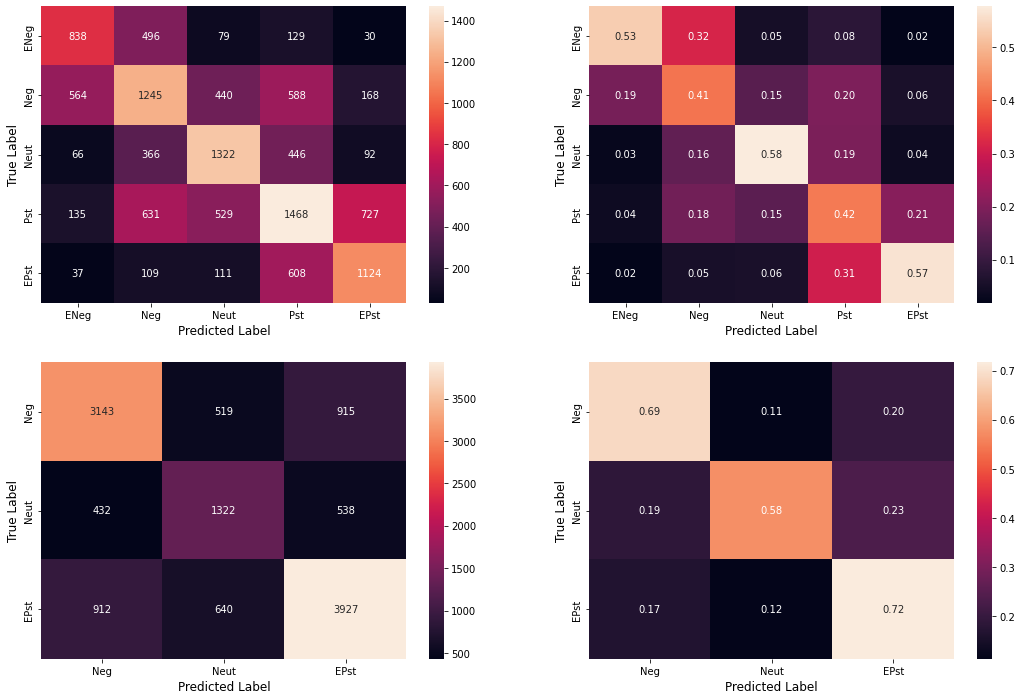

In [ ]:
evaluation_metrics(y_train, train_preds , y_test , test_preds)

## Naive Baye TFidf vectoriser 

In [ ]:
NBT_model = MultinomialNB().fit(train_tfidf_array,y_train)

In [ ]:
train_preds = NBT_model.predict(train_tfidf_array)
test_preds = NBT_model.predict(test_tfidf_array)

RMSE training Error: 1.96
RMSE testing errot: 1.81


classification report train data
              precision    recall  f1-score   support

          -3       0.81      0.28      0.42      3909
          -2       0.50      0.62      0.55      6912
           0       0.71      0.49      0.58      5421
           2       0.46      0.78      0.58      7932
           3       0.82      0.32      0.46      4635

    accuracy                           0.55     28809
   macro avg       0.66      0.50      0.52     28809
weighted avg       0.62      0.55      0.53     28809



classification report test data
              precision    recall  f1-score   support

          -3       0.68      0.20      0.31      1572
          -2       0.42      0.52      0.47      3005
           0       0.63      0.39      0.48      2292
           2       0.41      0.71      0.52      3490
           3       0.71      0.26      0.38      1989

    accuracy                           0.47     12348
   macro av

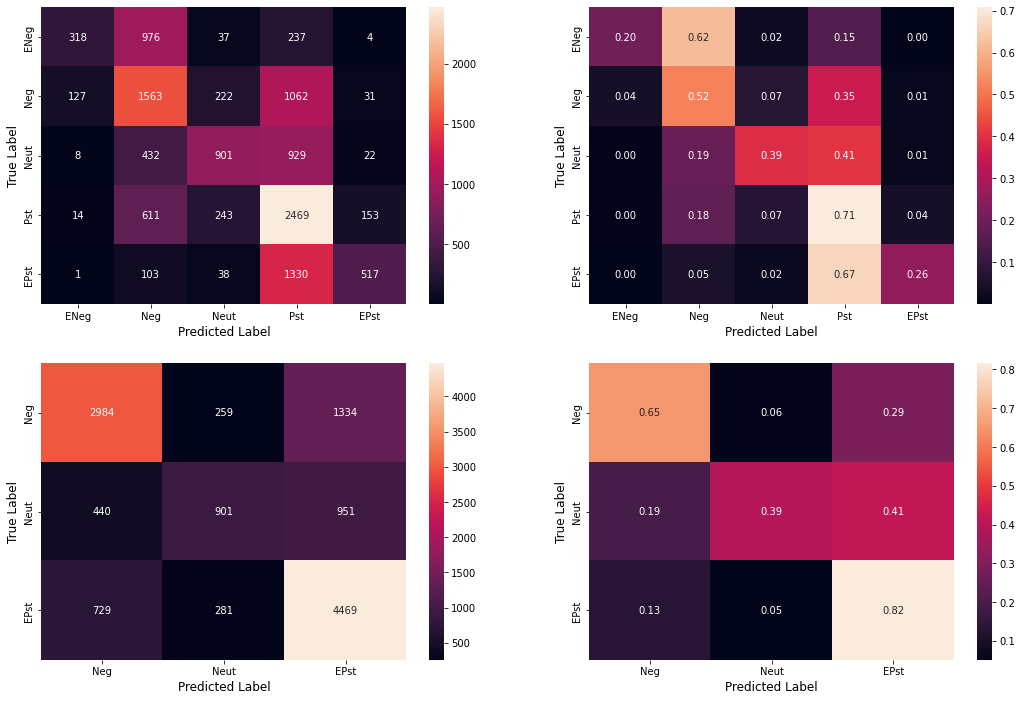

In [ ]:
evaluation_metrics(y_train, train_preds, y_test, test_preds)

* The baseline accuracy is 48 % we will try to beat this with other Ml models

# Random forest Classifier (tfidf_vectorizer)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()


In [ ]:
#Create the random grid
param_grid = {'n_estimators': [50],
               'max_depth': [ 50 , 80],
               'min_samples_split': [6 ],
               'min_samples_leaf': [4 ,6 ]}
# param_grid = {'n_estimators': [50],
#                'max_depth': [ 80],
#                'min_samples_split': [6 ],
#                'min_samples_leaf': [4 ]}

In [ ]:
grid_rf_clf = GridSearchCV(rf_clf, param_grid, cv=5)

In [ ]:
grid_rf_clf.fit(train_tfidf_array,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [50, 80], 'min_samples_leaf': [4, 6],
                         'min_samples_split': [6], 'n_estimators': [50]})

In [ ]:
grid_rf_clf.best_params_

{'max_depth': 80,
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'n_estimators': 50}

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/grid_rf_clf' , 'wb') as f:
  pickle.dump(grid_rf_clf,f)

In [ ]:
# with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/grid_rf_clf' , 'rb') as f:
#   grid_rf_clf = pickle.load(f)

In [ ]:
train_preds = grid_rf_clf.predict(train_tfidf_array)
test_preds = grid_rf_clf.predict(test_tfidf_array)

RMSE training Error: 1.92
RMSE testing errot: 1.57


classification report train data
              precision    recall  f1-score   support

          -3       0.81      0.57      0.67      3909
          -2       0.68      0.66      0.67      6912
           0       0.66      0.72      0.69      5421
           2       0.62      0.77      0.68      7932
           3       0.82      0.63      0.71      4635

    accuracy                           0.68     28809
   macro avg       0.72      0.67      0.68     28809
weighted avg       0.70      0.68      0.68     28809



classification report test data
              precision    recall  f1-score   support

          -3       0.60      0.42      0.49      1572
          -2       0.47      0.45      0.46      3005
           0       0.56      0.61      0.58      2292
           2       0.45      0.59      0.51      3490
           3       0.61      0.42      0.49      1989

    accuracy                           0.51     12348
   macro av

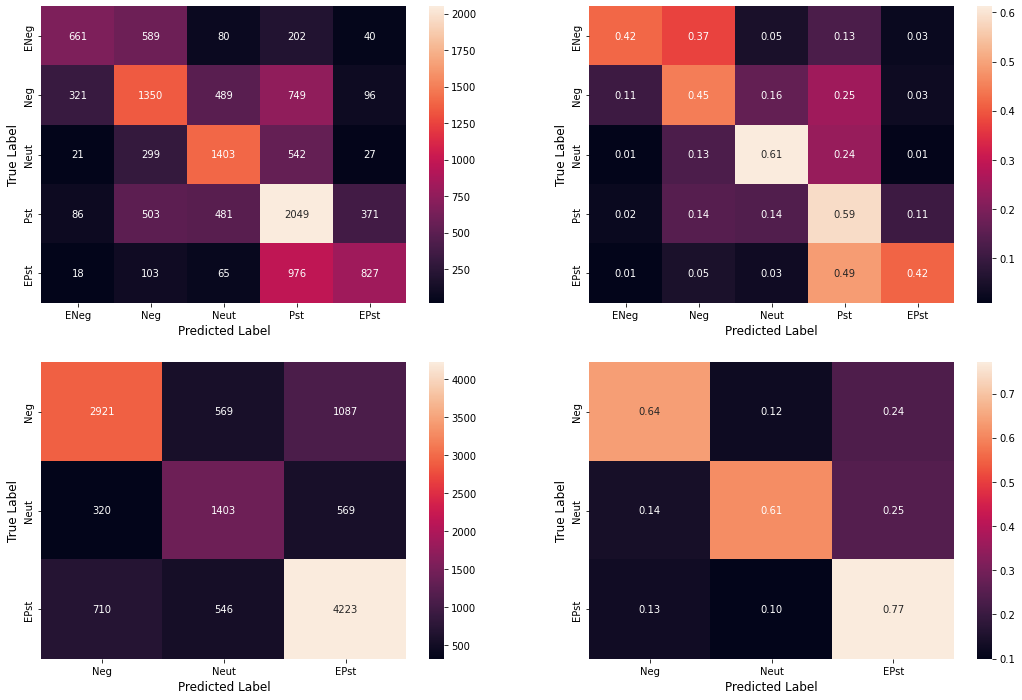

In [ ]:
evaluation_metrics(y_train, train_preds, y_test, test_preds)

# Catboost

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 58 kB/s 


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
# we will agin split the data to get validation set
X_train_c, X_eval,y_train_c,y_eval = train_test_split(train_tfidf_array , y_train,test_size=0.2 , random_state=42)

In [ ]:
cb_clf= CatBoostClassifier()

In [ ]:
cb_clf.fit(X_train_c, y_train_c,  
        eval_set=(X_eval, y_eval), 
        verbose=True
)

In [ ]:
train_preds = cb_clf.predict(train_tfidf_array)
test_preds = cb_clf.predict(test_tfidf_array)

In [ ]:
# evaluation_metrics(y_train, train_preds, y_test, test_preds)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/catboost_model' , 'wb') as f:
  pickle.dump(cb_clf,f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/catboost_model' , 'rb') as f:
  cb_clf = pickle.load(f)

In [ ]:
train_preds = cb_clf.predict(train_tfidf_array)
test_preds = cb_clf.predict(test_tfidf_array)

RMSE training Error: 1.67
RMSE testing errot: 1.5


classification report train data
              precision    recall  f1-score   support

          -3       0.76      0.61      0.68      3909
          -2       0.64      0.63      0.63      6912
           0       0.68      0.77      0.72      5421
           2       0.62      0.71      0.66      7932
           3       0.80      0.62      0.69      4635

    accuracy                           0.67     28809
   macro avg       0.70      0.67      0.68     28809
weighted avg       0.68      0.67      0.67     28809



classification report test data
              precision    recall  f1-score   support

          -3       0.63      0.50      0.56      1572
          -2       0.54      0.52      0.53      3005
           0       0.63      0.74      0.68      2292
           2       0.55      0.63      0.59      3490
           3       0.71      0.54      0.61      1989

    accuracy                           0.59     12348
   macro avg

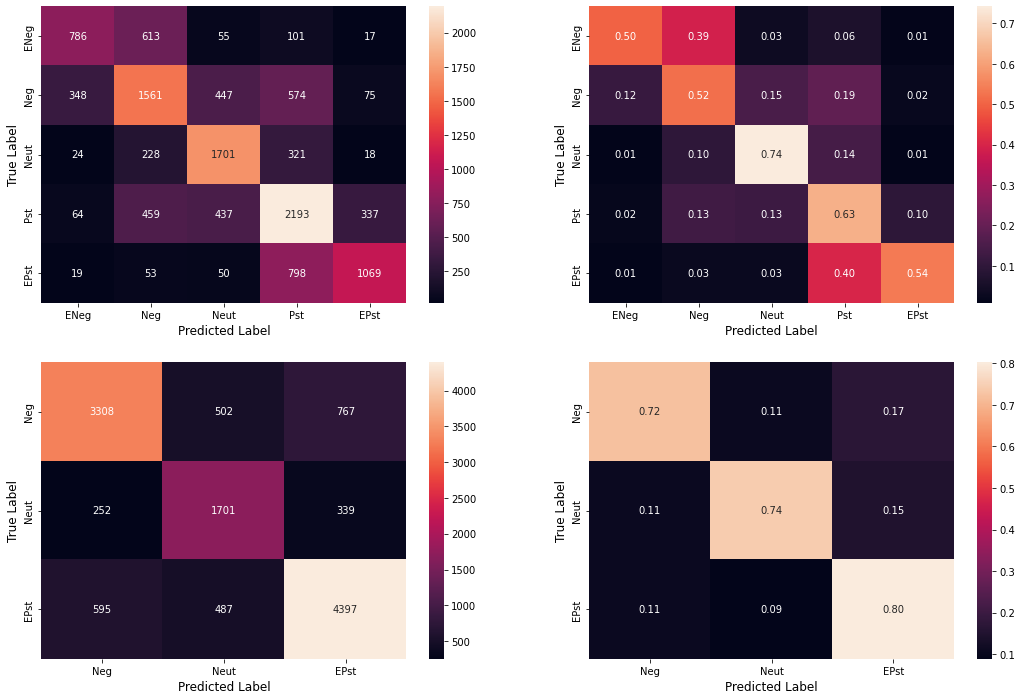

In [ ]:
evaluation_metrics(y_train, train_preds, y_test, test_preds)

# Logistic Regression Multiclass

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg_clf = LogisticRegression(max_iter= 400 , random_state=42)

In [ ]:
log_reg_clf.fit(train_tfidf_array,y_train)

LogisticRegression(max_iter=400, random_state=42)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/log_reg_model' , 'wb') as f:
  pickle.dump(log_reg_clf,f)

In [ ]:
# with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/log_reg_model' , 'rb') as f:
#   log_reg_clf = pickle.load(f)

In [ ]:
train_preds = log_reg_clf.predict(train_cv_array)
test_preds = log_reg_clf.predict(test_cv_array)

RMSE training Error: 1.89
RMSE testing errot: 1.74


classification report train data
              precision    recall  f1-score   support

          -3       0.50      0.86      0.64      3909
          -2       0.67      0.41      0.51      6912
           0       0.72      0.67      0.69      5421
           2       0.66      0.46      0.54      7932
           3       0.54      0.85      0.66      4635

    accuracy                           0.61     28809
   macro avg       0.62      0.65      0.61     28809
weighted avg       0.63      0.61      0.59     28809



classification report test data
              precision    recall  f1-score   support

          -3       0.43      0.77      0.56      1572
          -2       0.52      0.31      0.39      3005
           0       0.63      0.59      0.61      2292
           2       0.54      0.37      0.44      3490
           3       0.49      0.78      0.60      1989

    accuracy                           0.51     12348
   macro av

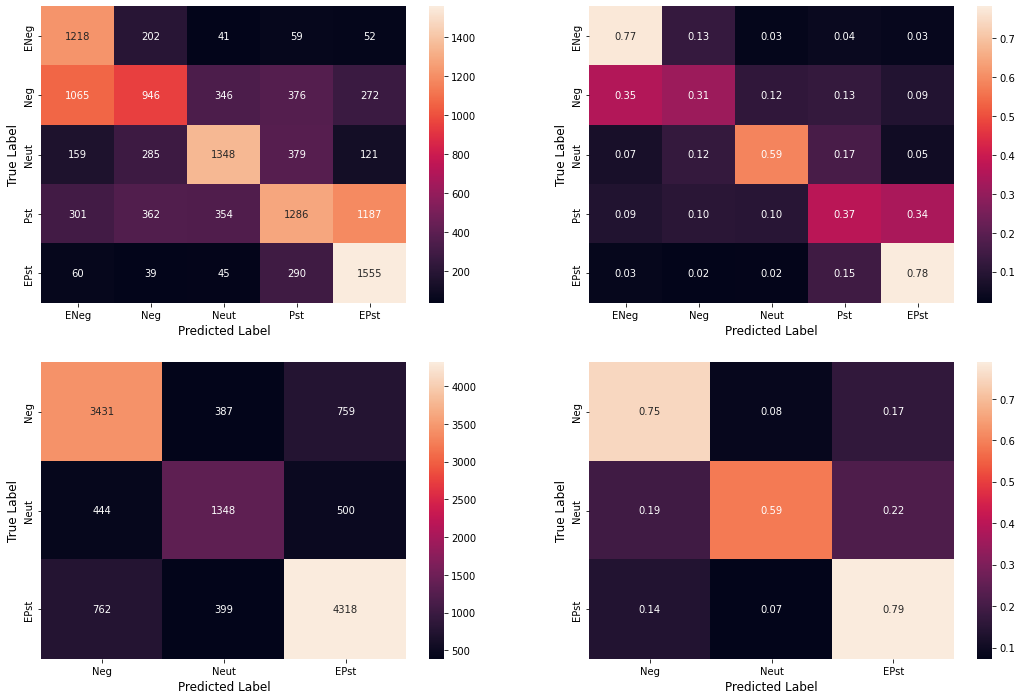

In [ ]:
evaluation_metrics(y_train, train_preds , y_test , test_preds)

# xgboost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
xgboost = GradientBoostingClassifier(random_state=42 , n_estimators= 50 ,verbose=1)

In [ ]:
xgboost.fit(train_tfidf_array,y_train)

      Iter       Train Loss   Remaining Time 
         1           1.5512           22.36m
         2           1.5318           18.74m
         3           1.5160           16.26m
         4           1.5026           14.92m
         5           1.4908           13.99m
         6           1.4799           13.33m
         7           1.4709           12.74m
         8           1.4625           12.30m
         9           1.4550           11.83m
        10           1.4476           11.41m
        20           1.3922            8.17m
        30           1.3538            5.40m
        40           1.3234            2.66m
        50           1.2984            0.00s


GradientBoostingClassifier(n_estimators=50, random_state=42, verbose=1)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/xgboost' , 'wb') as f:
  pickle.dump(xgboost,f)

In [ ]:
# with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/xgboost' , 'rb') as f:
#   xgboost_m = pickle.load(f)

In [ ]:
train_preds = xgboost.predict(train_tfidf_array)
test_preds = xgboost.predict(test_tfidf_array)

RMSE training Error: 1.89
RMSE testing errot: 1.74


classification report train data
              precision    recall  f1-score   support

          -3       0.50      0.86      0.64      3909
          -2       0.67      0.41      0.51      6912
           0       0.72      0.67      0.69      5421
           2       0.66      0.46      0.54      7932
           3       0.54      0.85      0.66      4635

    accuracy                           0.61     28809
   macro avg       0.62      0.65      0.61     28809
weighted avg       0.63      0.61      0.59     28809



classification report test data
              precision    recall  f1-score   support

          -3       0.43      0.77      0.56      1572
          -2       0.52      0.31      0.39      3005
           0       0.63      0.59      0.61      2292
           2       0.54      0.37      0.44      3490
           3       0.49      0.78      0.60      1989

    accuracy                           0.51     12348
   macro av

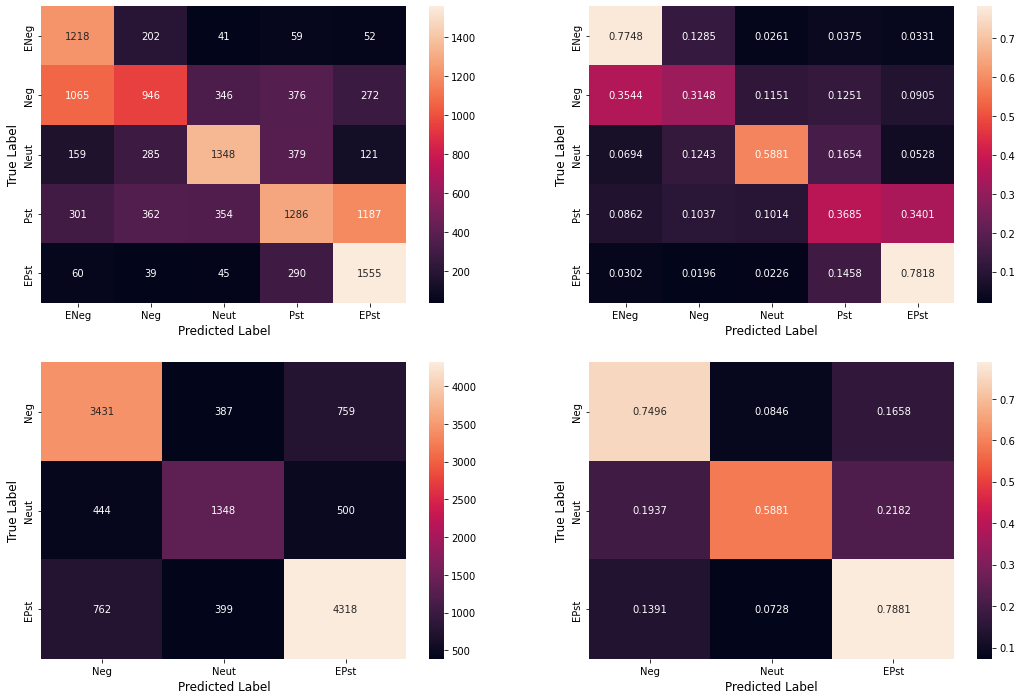

In [ ]:
evaluation_metrics(y_train, train_preds, y_test, test_preds)

# Comparision of all models

|Modle | RMSE | Accuracy (5 labels ) |accuracy (3 labels)  |
|:--:|:--:| :--:|:--:|
|Naive Bayes |1.83|0.49|0.68|
|Xgboost|1.74|0.51|0.74|
|Random Forest|1.57|0.51|0.69|
|logistic Regression|1.74|0.52|0.74|
|catboost|1.5|0.59|0.76|

* we have used naive bayes as baseline model
* catboost gives the best performance amog the all models with 59% accuracy
* catboost also gives smallet Rmse and 76% accuracy if we consider only 3 labels